[*********************100%***********************]  3 of 3 completed
/var/folders/c0/_b6c00gj3x56bbmcgtgs73gr0000gn/T/ipykernel_81111/4007106309.py:41: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Signal'][20:] = (data['VOO_MA20'][20:

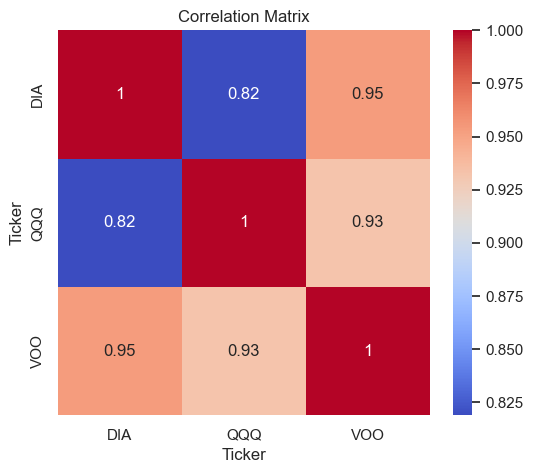

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


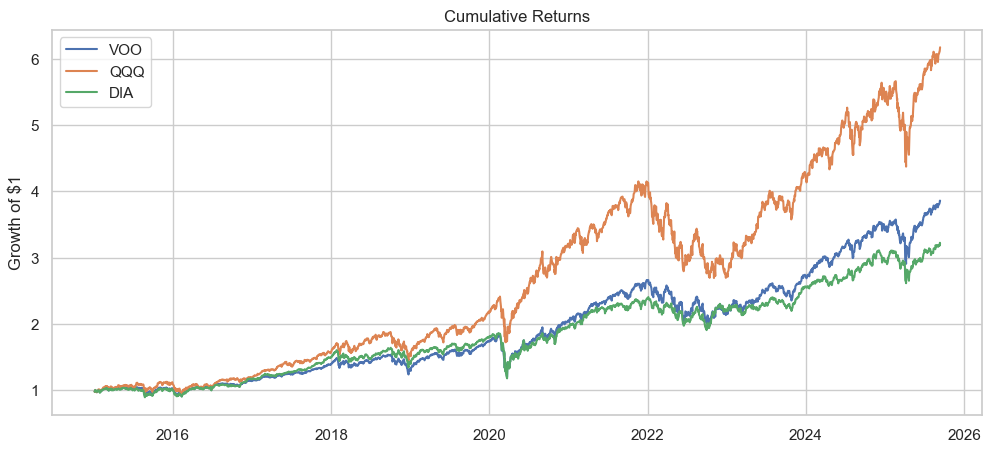

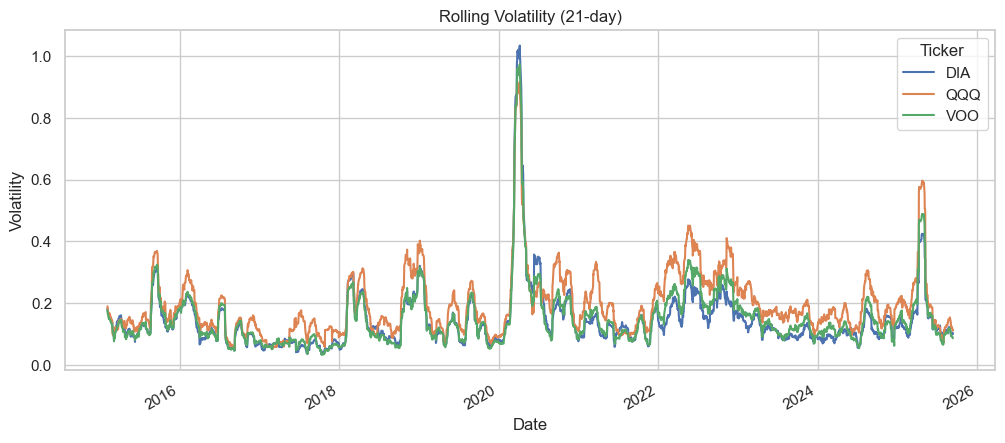

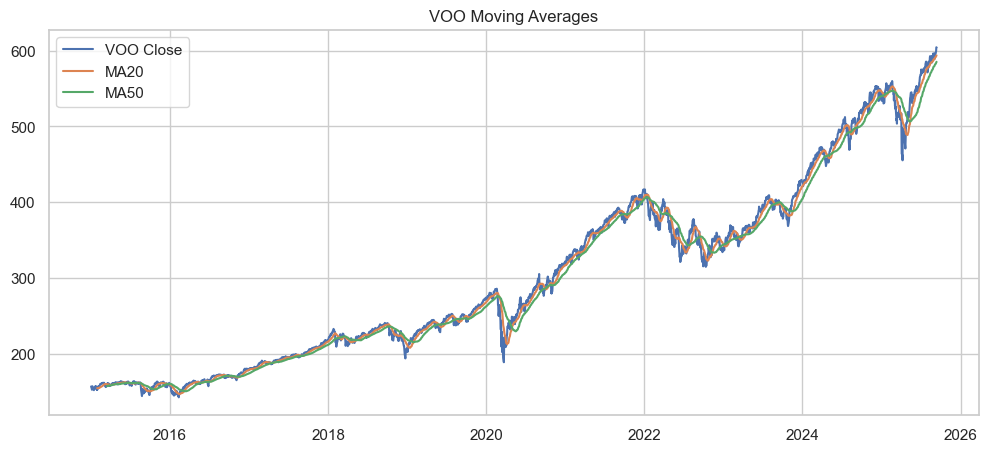

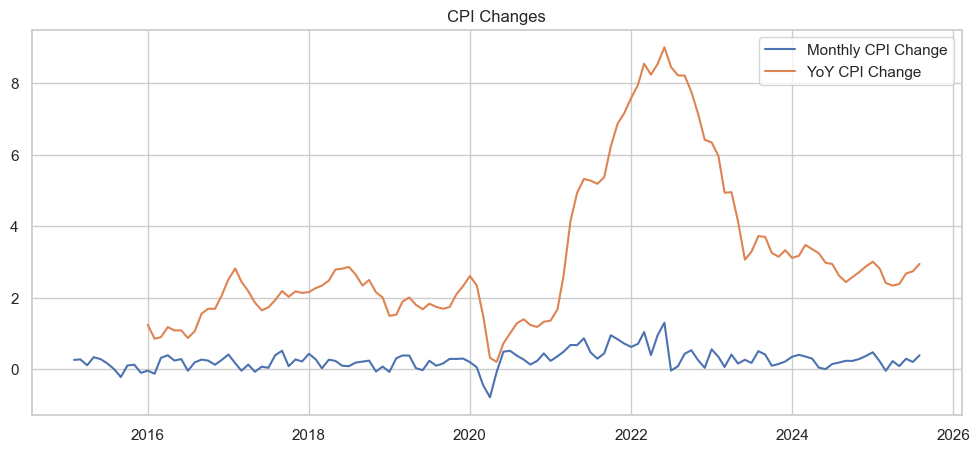

In [7]:
# ============================
# Daily Market & Economic Analysis
# ============================

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itables import init_notebook_mode, show
from datetime import datetime


# ----------------------------
# 1️⃣ Setup
# ----------------------------
init_notebook_mode(all_interactive=True)
sns.set(style="whitegrid")

start_date = '2015-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')  # current date in 'YYYY-MM-DD'

# ----------------------------
# 2️⃣ Market Data Download
# ----------------------------
tickers = ["VOO", "QQQ", "DIA"]  # Example ETFs
data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)['Close']

# ----------------------------
# 3️⃣ Compute Returns & Metrics
# ----------------------------
returns = data.pct_change()
cumulative_returns = (1 + returns).cumprod()
rolling_vol = returns.rolling(21).std() * (252**0.5)  # 21-day rolling annualized volatility

# ----------------------------
# 4️⃣ Moving Averages
# ----------------------------
data['VOO_MA20'] = data['VOO'].rolling(20).mean()
data['VOO_MA50'] = data['VOO'].rolling(50).mean()
data['Signal'] = 0
data['Signal'][20:] = (data['VOO_MA20'][20:] > data['VOO_MA50'][20:]).astype(int)

# ----------------------------
# 5️⃣ Correlation Analysis
# ----------------------------
corr_matrix = returns.corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# ----------------------------
# 6️⃣ Interactive Table
# ----------------------------
# Make sure we only take the original tickers, not MA or Signal columns
perf_df = pd.DataFrame({
    'Ticker': tickers,
    'Last Close': data[tickers].iloc[-1],
    'Daily Return (%)': returns[tickers].iloc[-1]*100,
    '21D Rolling Vol (%)': rolling_vol[tickers].iloc[-1]*100
}).reset_index(drop=True)
show(
    perf_df,
    classes="display compact cell-border",
    scrollY="300px",
    scrollCollapse=True,
    paging=False,
    columnDefs=[
        {"targets": [2,3],
         "render": "function(data,type,row,meta){if(type==='display'){return data.toFixed(2)+'%';} return data;}"}
    ]
)

# ----------------------------
# 7️⃣ Plotting
# ----------------------------
plt.figure(figsize=(12,5))
for t in tickers:
    plt.plot(cumulative_returns[t], label=t)
plt.title("Cumulative Returns")
plt.ylabel("Growth of $1")
plt.legend()
plt.show()

# Rolling volatility plot
rolling_vol.plot(figsize=(12,5), title="Rolling Volatility (21-day)")
plt.ylabel("Volatility")
plt.show()

# Moving averages plot
plt.figure(figsize=(12,5))
plt.plot(data['VOO'], label='VOO Close')
plt.plot(data['VOO_MA20'], label='MA20')
plt.plot(data['VOO_MA50'], label='MA50')
plt.title("VOO Moving Averages")
plt.legend()
plt.show()

# ----------------------------
# 8️⃣ Economic Data Example (FRED)
# ----------------------------
try:
    from pandas_datareader import data as pdr
    cpi = pdr.DataReader('CPIAUCSL', 'fred', start_date , end_date)
    # Keep only the CPI column as a Series
    cpi_series = cpi['CPIAUCSL']

    # Monthly and YoY changes
    cpi['Monthly Change (%)'] = cpi_series.pct_change()*100
    cpi['YoY Change (%)'] = cpi_series.pct_change(12)*100

    plt.figure(figsize=(12,5))
    plt.plot(cpi['Monthly Change (%)'], label='Monthly CPI Change')
    plt.plot(cpi['YoY Change (%)'], label='YoY CPI Change')
    plt.title("CPI Changes")
    plt.legend()
    plt.show()

except Exception as e:
    print("Error fetching economic data:", e)


[*********************100%***********************]  11 of 11 completed


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


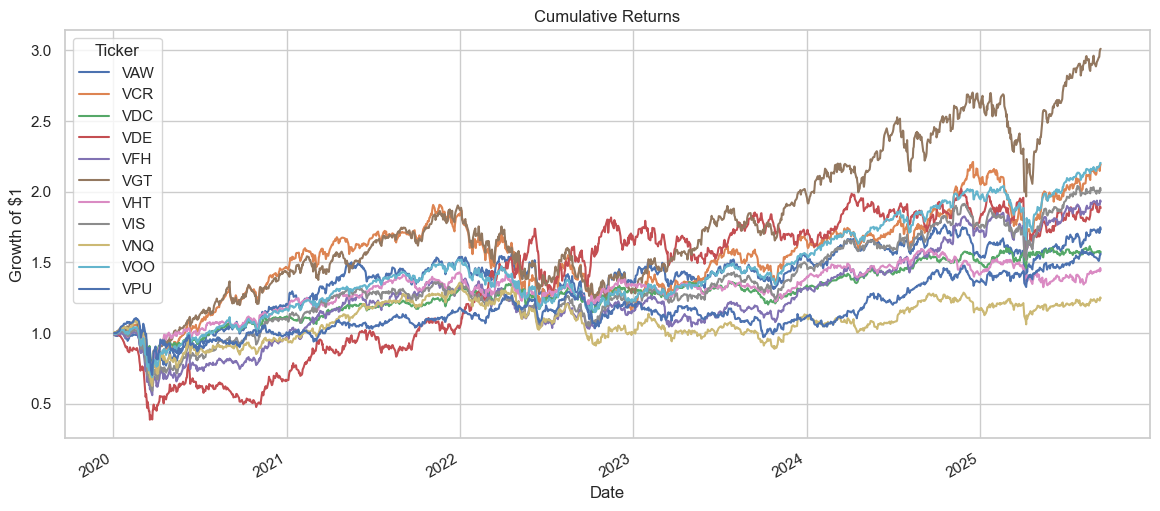

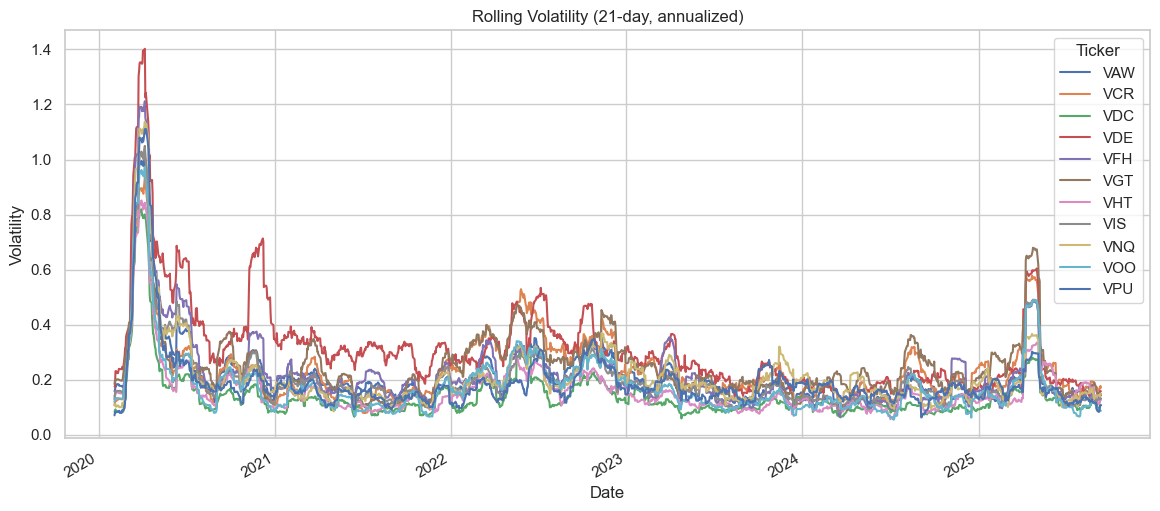

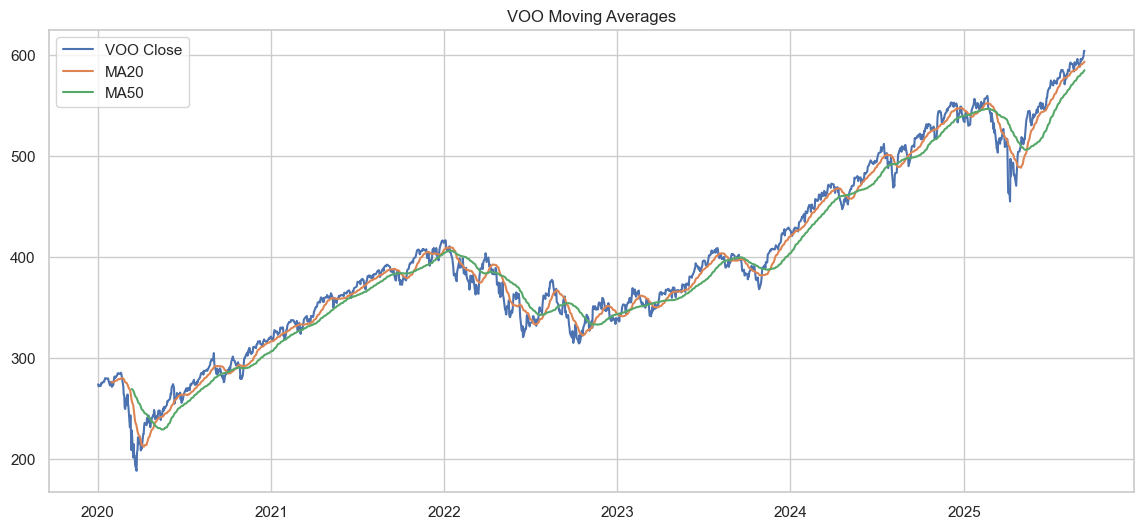

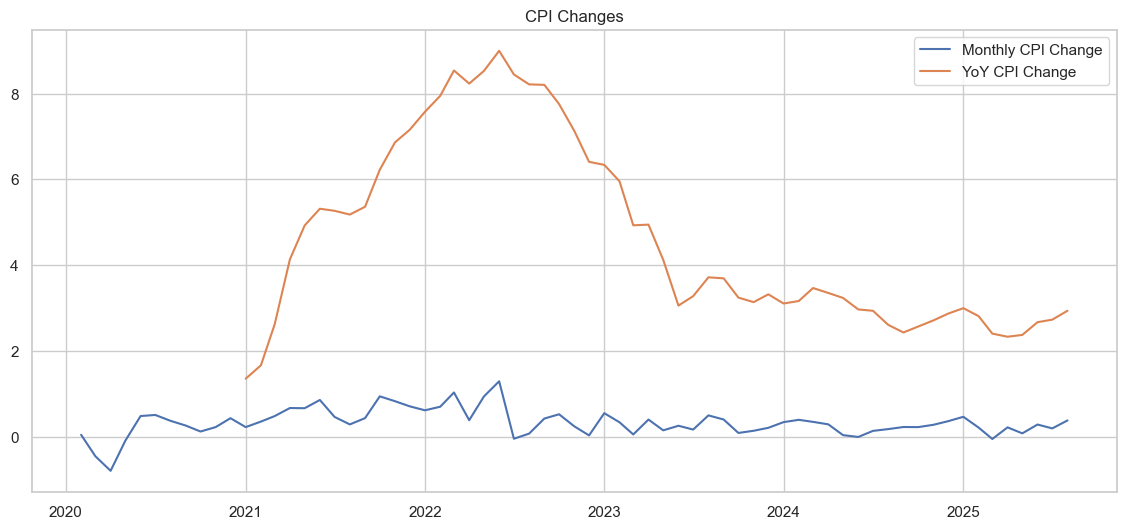

In [11]:
# ===========================================
# Vanguard Market & Economic Dashboard
# ===========================================

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itables import init_notebook_mode, show
from datetime import datetime
from pandas_datareader import data as pdr
import warnings
warnings.filterwarnings("ignore")

# ----------------------------
# 1️⃣ Setup
# ----------------------------
init_notebook_mode(all_interactive=True)
sns.set(style="whitegrid")

# ----------------------------
# 2️⃣ Vanguard ETFs & Dates
# ----------------------------
vanguard_sector_dict = {
    "VFH": "Financials",
    "VGT": "Technology",
    "VDE": "Energy",
    "VCR": "Consumer Discretionary",
    "VDC": "Consumer Staples",
    "VHT": "Health Care",
    "VIS": "Industrials",
    "VPU": "Utilities",
    "VNQ": "Real Estate",
    "VAW": "Materials"
}

# Include VOO as benchmark
tickers = ["VOO"] + list(vanguard_sector_dict.keys())

start_date = '2020-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# ----------------------------
# 3️⃣ Download Market Data
# ----------------------------
data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)['Close']

# ----------------------------
# 4️⃣ Calculate Multi-Period Returns
# ----------------------------
periods = {
    "Daily": 1,
    "Monthly": 21,
    "Quarterly": 63,
    "Semiannual": 126,
    "Annual": 252,
    "3-Year": 252*3
}

performance = {}
for label, days in periods.items():
    performance[label] = data.pct_change(periods=days).iloc[-1] * 100

perf_df = pd.DataFrame(performance)
perf_df['Ticker'] = perf_df.index
perf_df['Sector'] = [vanguard_sector_dict.get(t, "Benchmark") for t in perf_df['Ticker']]
perf_df = perf_df[['Sector', 'Ticker'] + list(periods.keys())]

# ----------------------------
# 5️⃣ Interactive Table (fixed)
# ----------------------------
show(
    perf_df.sort_values(by="Monthly", ascending=False).reset_index(drop=True),
    classes="display compact cell-border",
    scrollY="400px",
    scrollCollapse=True,
    paging=False,
    columnDefs=[
        {
            "targets": list(range(2, 2+len(periods))),
            "render": "function(data,type,row,meta){if(type==='display'){return data.toFixed(2)+'%';} return data;}"
        }
    ]
)

# ----------------------------
# 6️⃣ Cumulative Returns
# ----------------------------
cumulative_returns = (1 + data.pct_change()).cumprod()
cumulative_returns.plot(figsize=(14,6), title="Cumulative Returns")
plt.ylabel("Growth of $1")
plt.show()

# ----------------------------
# 7️⃣ Rolling Volatility
# ----------------------------
rolling_vol = data.pct_change().rolling(21).std() * np.sqrt(252)
rolling_vol.plot(figsize=(14,6), title="Rolling Volatility (21-day, annualized)")
plt.ylabel("Volatility")
plt.show()

# ----------------------------
# 8️⃣ Moving Averages for VOO
# ----------------------------
data['VOO_MA20'] = data['VOO'].rolling(20).mean()
data['VOO_MA50'] = data['VOO'].rolling(50).mean()
plt.figure(figsize=(14,6))
plt.plot(data['VOO'], label='VOO Close')
plt.plot(data['VOO_MA20'], label='MA20')
plt.plot(data['VOO_MA50'], label='MA50')
plt.title("VOO Moving Averages")
plt.legend()
plt.show()

# ----------------------------
# 9️⃣ Economic Data (CPI)
# ----------------------------
try:
    cpi = pdr.DataReader('CPIAUCSL', 'fred', start_date, end_date)
    cpi_series = cpi['CPIAUCSL']
    cpi['Monthly Change (%)'] = cpi_series.pct_change()*100
    cpi['YoY Change (%)'] = cpi_series.pct_change(12)*100

    plt.figure(figsize=(14,6))
    plt.plot(cpi['Monthly Change (%)'], label='Monthly CPI Change')
    plt.plot(cpi['YoY Change (%)'], label='YoY CPI Change')
    plt.title("CPI Changes")
    plt.legend()
    plt.show()
except Exception as e:
    print("Error fetching economic data:", e)
